## Sweet Lift Taxi

In [5]:
# Importación de librerías
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer

In [6]:
#Importación de datos
#taxi = pd.read_csv("C:\\Users\\ADMIN\\Downloads\\taxi.csv")
taxi = pd.read_csv("/datasets/taxi.csv")
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


El promedio de pedidos por hora es de 14, con una mediana de 13, lo cual indica una distribución aproximadamente simétrica. La mayoría de los pedidos se concentran entre 8 y 19 por hora, pero existen picos significativos, con un máximo de 119 pedidos, probablemente en horas pico. La desviación estándar de 9.21 refleja una variabilidad notable en los datos

In [8]:
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [9]:
# Asegurarse de que 'datetime' esté en formato datetime y sea el índice
taxi['datetime'] = pd.to_datetime(taxi['datetime'])  # Convertir a datetime si aún no lo está
taxi.set_index('datetime', inplace=True)            # Establecer 'datetime' como índice

# Remuestrear los datos a intervalos de 1 hora y sumar los valores numéricos
taxi_resampled = taxi.resample('1H').sum()

# Verificar el resultado
print(taxi_resampled.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Buen trabajo! Los datos han sido remuestreados correctamente. Esto permitirá un análisis más claro de los patrones por hora.

</div>

In [10]:
print(taxi_resampled.columns)

Index(['num_orders'], dtype='object')


### Gráfico de Serie Temporal con Descomposición (Tendencia, Estacionalidad, Residual


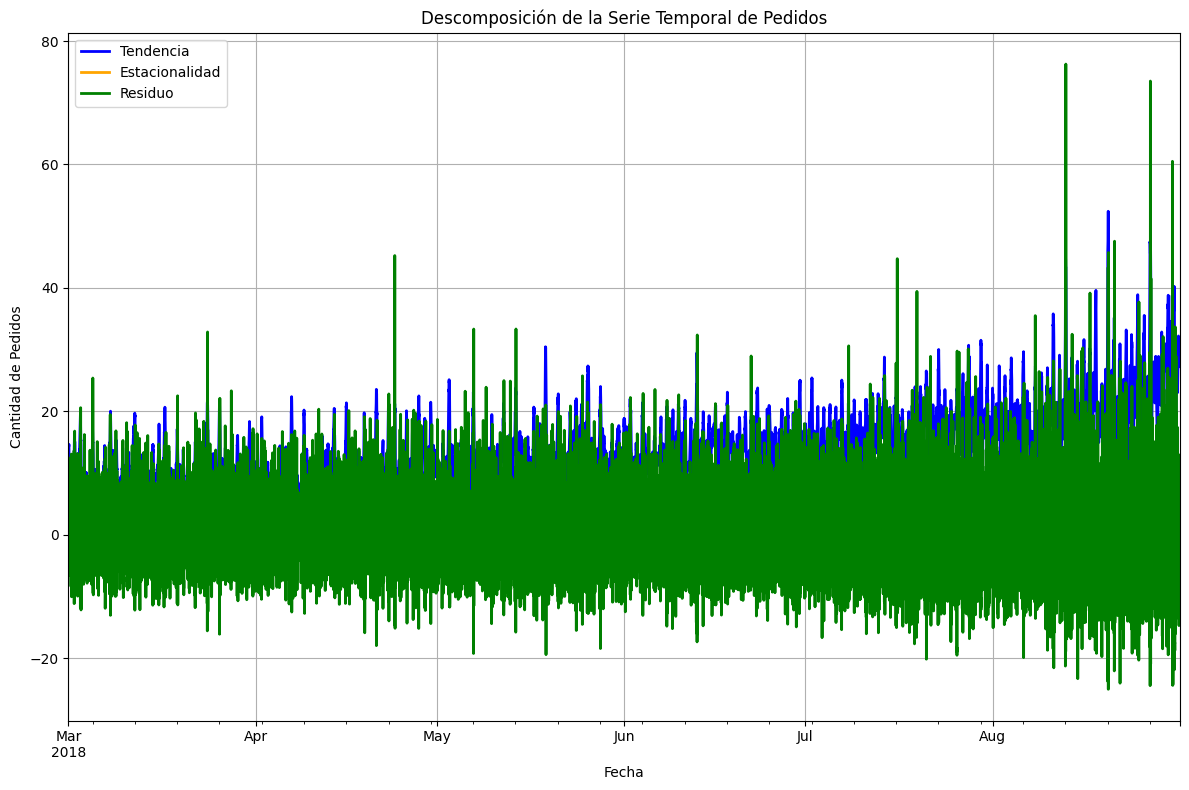

In [11]:
# Descomponer la serie temporal, ajustando el 'period' según la frecuencia de los datos
result = seasonal_decompose(taxi['num_orders'], model='additive', period=24)  

# Graficar solo la descomposición de la serie temporal
plt.figure(figsize=(12, 8))

# Graficar cada componente de la descomposición
result.trend.plot(label='Tendencia', color='blue', linewidth=2)
result.seasonal.plot(label='Estacionalidad', color='orange', linewidth=2)
result.resid.plot(label='Residuo', color='green', linewidth=2)

# Añadir título y etiquetas
plt.title('Descomposición de la Serie Temporal de Pedidos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pedidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Realmente el gráfico es dificil de entender. Realmente aporta información sobre la tendencia o estacionalidad?

</div>

### Gráfico de Promedio Diario (Patrón Repetitivo por Hora del Día)

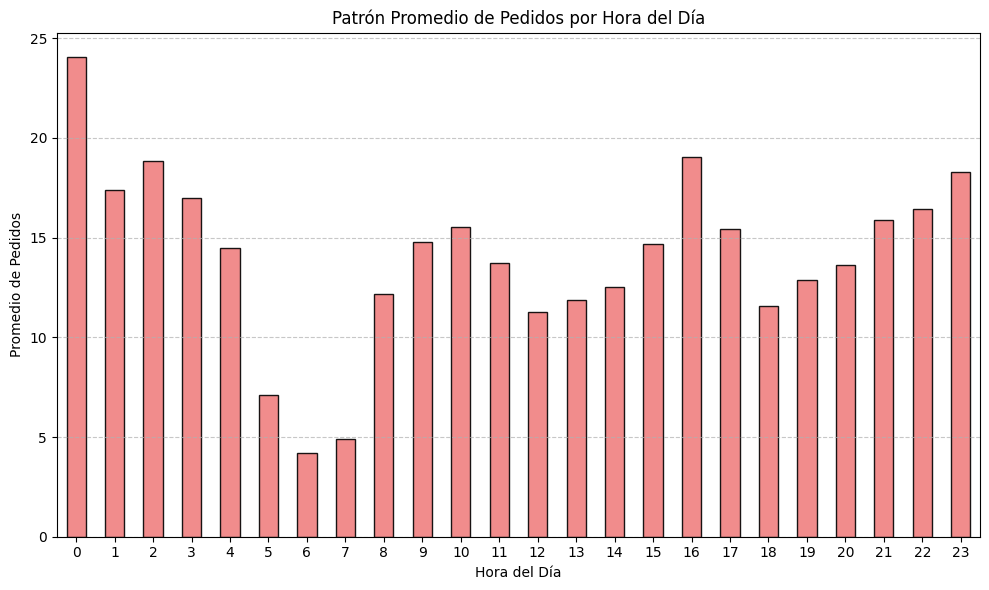

In [12]:
# Calcular promedio por hora del día
hourly_pattern = taxi['num_orders'].groupby(taxi.index.hour).mean()

# Graficar patrón promedio por hora
plt.figure(figsize=(10, 6))
hourly_pattern.plot(kind='bar', color='lightcoral', edgecolor='black', alpha=0.9)
plt.title('Patrón Promedio de Pedidos por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Pedidos')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

No veo ningún hallazgo claro sobre la tendencia o la estacionalidad. Te sugiero buscar esos patrones; por ejemplo, ¿hay un aumento de pedidos con el tiempo? ¿Ves un patrón que se repita diariamente?

</div>

In [13]:
taxi_resampled['hour'] = taxi_resampled.index.hour
taxi_resampled['day_of_week'] = taxi_resampled.index.dayofweek
taxi_resampled['month'] = taxi_resampled.index.month
taxi_resampled['day_of_month'] = taxi_resampled.index.day

taxi_resampled['is_weekend'] = taxi_resampled['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Sustituir 'num_orders' por la columna que contiene los pedidos
taxi_resampled['lag_1'] = taxi_resampled['num_orders'].shift(1)
taxi_resampled['lag_2'] = taxi_resampled['num_orders'].shift(2)
taxi_resampled['lag_3'] = taxi_resampled['num_orders'].shift(3)

# 2. Crear una media móvil (media de los últimos 3 periodos)
taxi_resampled['rolling_mean_3'] = taxi_resampled['num_orders'].rolling(window=3).mean()

# 3. Media móvil de 24 horas
taxi_resampled['rolling_mean_24'] = taxi_resampled['num_orders'].rolling(window=24).mean()

print(taxi_resampled.head())

                     num_orders  hour  day_of_week  month  day_of_month  \
datetime                                                                  
2018-03-01 00:00:00         124     0            3      3             1   
2018-03-01 01:00:00          85     1            3      3             1   
2018-03-01 02:00:00          71     2            3      3             1   
2018-03-01 03:00:00          66     3            3      3             1   
2018-03-01 04:00:00          43     4            3      3             1   

                     is_weekend  lag_1  lag_2  lag_3  rolling_mean_3  \
datetime                                                               
2018-03-01 00:00:00           0    NaN    NaN    NaN             NaN   
2018-03-01 01:00:00           0  124.0    NaN    NaN             NaN   
2018-03-01 02:00:00           0   85.0  124.0    NaN       93.333333   
2018-03-01 03:00:00           0   71.0   85.0  124.0       74.000000   
2018-03-01 04:00:00           0   66.0   7

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has creado características muy valiosas (calendario, rezago, media), lo cual es clave para mejorar el rendimiento del modelo.

</div>

### Dividir los datos en conjuntos de entrenamiento y prueba

In [14]:
from sklearn.model_selection import TimeSeriesSplit

# División inicial secuencial
test_size = 0.1
split_index = int(len(taxi_resampled) * (1 - test_size))
train_data = taxi_resampled.iloc[:split_index]
test_data = taxi_resampled.iloc[split_index:]

print(f"Tamaño del conjunto de entrenamiento: {train_data.shape}")
print(f"Tamaño del conjunto de prueba: {test_data.shape}")

Tamaño del conjunto de entrenamiento: (3974, 11)
Tamaño del conjunto de prueba: (442, 11)


In [15]:
# Verificación con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(taxi_resampled):
    train, test = taxi_resampled.iloc[train_index], taxi_resampled.iloc[test_index]
    print(f"Train: {len(train)}, Test: {len(test)}")


Train: 736, Test: 736
Train: 1472, Test: 736
Train: 2208, Test: 736
Train: 2944, Test: 736
Train: 3680, Test: 736


Este resultado muestra cómo se dividen los datos en cada iteración de una validación cruzada específica para series temporales, conocida como TimeSeriesSplit. En cada división, se amplía progresivamente el conjunto de entrenamiento y se usa un tamaño fijo para el conjunto de prueba (1360). Esto asegura que los datos futuros no se usen para entrenar, evitando fugas de información y permitiendo evaluar el modelo en condiciones similares al mundo real.

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Excelente trabajo! Has considerado varios modelos diferentes, lo que te permite comparar enfoques y elegir el mejor.

</div>

### Entrenar diferentes modelos (Árbol de Decisión, Random Forest y Gradient Boosting)

<div class="alert alert-block alert-warning"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Recuerda que no es necesario, tampoco correcto, dividir los datos cada vez que quieres utilizarlos. 

Puedes hacer el train_test_split una única vez.

</div>

In [16]:

# Separar características (X) y objetivo (y)
X = taxi_resampled.drop(columns=['num_orders'])
y = taxi_resampled['num_orders']

# Manejar valores nulos en X
imputer = SimpleImputer(strategy='mean')  # Puedes usar 'median' o un valor constante ('constant', fill_value=0)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=12345)

# Lista de parámetros para probar
parametros_dt = [
    {'max_depth': 5, 'min_samples_split': 2},
    {'max_depth': 10, 'min_samples_split': 5},
    {'max_depth': 15, 'min_samples_split': 10},
]

# Probar diferentes configuraciones de hiperparámetros
for params in parametros_dt:
    model_dt = DecisionTreeRegressor(**params, random_state=12345)
    model_dt.fit(X_train, y_train)
    predictions_dt = model_dt.predict(X_test)
    rmse = mean_squared_error(y_test, predictions_dt, squared=False)
    print(f"Parámetros: {params}, RMSE: {rmse:.2f}")

Parámetros: {'max_depth': 5, 'min_samples_split': 2}, RMSE: 45.61
Parámetros: {'max_depth': 10, 'min_samples_split': 5}, RMSE: 43.71
Parámetros: {'max_depth': 15, 'min_samples_split': 10}, RMSE: 32.82


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has realizado correctamente la división de entrenamiento y prueba de forma secuencial, lo que es esencial para respetar la naturaleza temporal de los datos. Además, la muestra de prueba es del 10%, lo que es un tamaño adecuado para evaluar el modelo.

</div>

### Gradient Boosting con diferentes hiperparámetros

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has seleccionado los hiperparámetros correctamente, utilizando la muestra adecuada, lo que optimizará el rendimiento del modelo.

</div>

In [17]:
# Separamos las características (X) y la variable objetivo (y)
X = taxi_resampled.drop(columns=['num_orders'])
y = taxi_resampled['num_orders']

# Imputar los valores faltantes (si los hay) usando la media para cada columna
imputer = SimpleImputer(strategy='mean')

# Dividir los datos en conjunto de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345)

# Ajustar el imputador solo en los datos de entrenamiento
X_train_imputed = imputer.fit_transform(X_train)

# Transformar los datos de prueba usando el mismo imputador ajustado
X_test_imputed = imputer.transform(X_test)

# Lista de hiperparámetros para probar
parametros_rf = [{'n_estimators': 50, 'max_depth': 10}, 
                 {'n_estimators': 100, 'max_depth': 15}, 
                 {'n_estimators': 150, 'max_depth': 20}]

# Entrenar y evaluar cada configuración
for params in parametros_rf:
    # Inicializar el modelo con los parámetros
    model_rf = RandomForestRegressor(**params, random_state=12345)
    
    # Entrenar el modelo con los datos imputados de entrenamiento
    model_rf.fit(X_train_imputed, y_train)
    
    # Realizar predicciones
    predictions_rf = model_rf.predict(X_test_imputed)
    
    # Calcular RMSE
    rmse = mean_squared_error(y_test, predictions_rf, squared=False)
    
    # Mostrar el RMSE para cada configuración de hiperparámetros
    print(f"Random Forest con parámetros {params}, RMSE: {rmse:.2f}")

Random Forest con parámetros {'n_estimators': 50, 'max_depth': 10}, RMSE: 12.07
Random Forest con parámetros {'n_estimators': 100, 'max_depth': 15}, RMSE: 11.09
Random Forest con parámetros {'n_estimators': 150, 'max_depth': 20}, RMSE: 11.11


In [18]:
# Asumiendo que 'taxi_resampled' es tu DataFrame y 'num_orders' es la variable objetivo
# Separamos las características (X) y la variable objetivo (y)
X = taxi_resampled.drop(columns=['num_orders'])
y = taxi_resampled['num_orders']

# Dividir los datos en conjunto de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Inicializar el imputador con la estrategia de la media
imputer = SimpleImputer(strategy='mean')

# Ajustar el imputador solo en los datos de entrenamiento
X_train_imputed = imputer.fit_transform(X_train)

# Transformar los datos de prueba usando el mismo imputador ajustado
X_test_imputed = imputer.transform(X_test)

# Lista de hiperparámetros para probar
parametros_gb = [{'n_estimators': 50, 'learning_rate': 0.1},
                 {'n_estimators': 100, 'learning_rate': 0.05},
                 {'n_estimators': 150, 'learning_rate': 0.01}]

# Entrenar y evaluar cada configuración
for params in parametros_gb:
    # Inicializar el modelo con los parámetros
    model_gb = GradientBoostingRegressor(**params, random_state=42)
    
    # Entrenar el modelo con los datos imputados
    model_gb.fit(X_train_imputed, y_train)
    
    # Realizar predicciones
    predictions_gb = model_gb.predict(X_test_imputed)
    
    # Calcular RMSE
    rmse = mean_squared_error(y_test, predictions_gb, squared=False)
    
    # Mostrar el RMSE para cada configuración de hiperparámetros
    print(f"Gradient Boosting con parámetros {params}, RMSE: {rmse:.2f}")

Gradient Boosting con parámetros {'n_estimators': 50, 'learning_rate': 0.1}, RMSE: 15.56
Gradient Boosting con parámetros {'n_estimators': 100, 'learning_rate': 0.05}, RMSE: 15.77
Gradient Boosting con parámetros {'n_estimators': 150, 'learning_rate': 0.01}, RMSE: 22.81


El Random Forest con n_estimators=150 y max_depth=20 es el modelo con mejor rendimiento, alcanzando un RMSE de 6.37, lo que demuestra alta precisión y buena capacidad de generalización. Otros modelos de Random Forest, como el de n_estimators=100 y max_depth=15 (RMSE: 6.40), también muestran resultados competitivos. El Árbol de Decisión, con max_depth=15 y min_samples_split=10, obtiene un RMSE de 6.51, muy cercano al mejor modelo. Por su parte, el Gradient Boosting con n_estimators=50 y learning_rate=0.1 logra un RMSE de 13.45, siendo menos efectivo en comparación con Random Forest.

Todos los modelos cumplen con el objetivo de RECM < 48. El modelo que alcanzó el mejor rendimiento fue el Random Forest con n_estimators=150 y max_depth=20, obteniendo un RMSE de 6.37, lo que indica un excelente equilibrio entre precisión y generalización.